# Instance Image Segmentation - Mask RCNN

**Introduction:**  
This Model has been initially build and trained on local windows 10 machine equipped with 12GB RAM (No GPU and TPU)and will be trained later on TPU via Colab 

Model has been trained to detect the follwoing objects from street:
* lane
* pedestrian
* sidewalk
* vehicle

**Local Environment  Specifications**  

* Windows 10 Enterprise
* python version(3.8.8)
* TensorFlow version(2.4.0) (Facing issues with 2.4.1)


**prerequisites**  
* Installing Tensorflow object Detections API's you can refer to below link [Installation Guide](http://https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html)<br>
* Install wget on your machine to clone github repository

Note: As part of this installation many other dependencies need to be installed as well, please make sure to go through all installation steps, theyare bit long and may you would face some challenges

**Import**

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import io
import sys
from json2xml import json2xml
from json2xml.utils import readfromurl, readfromstring, readfromjson
from xml.etree import ElementTree as ET
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import cv2 
import numpy as np
import tensorflow.compat.v1 as tf1

**Downloading Images**  
street images have been downloaded by using google map street view and stored under this path (images/resize)
only 30 images have been downloaded to avoid overloading our modest machine


**Resizeing**  

IF your workstation is not equipped with high RAM its highly recommended to resize the images  

**Note: In pipleline.config file the size in image resizer should be match with resized images you use in this step**  

You can resize the images in anaconda prompt by running the following line of code(make sure your images are available under
this path (images/resize)...Width height

**resize.py 400 300 images/resize/**

In [8]:
# Resize Function
def resize_image(width=800,hieght=600,path_to_images=os.getcwd() + '/images/resize/',working_dir=os.getcwd()):
    

    '''
    Args:
    path_to_images: string, path to images directory
    working_dir: path to the working directory if working directory differs than images directory
    size: new images size
    
    '''
    for img in os.listdir(path_to_images):
        directory = path_to_images + img
        image = Image.open(directory)
        image = image.resize((int(width),int(hieght)))
        if path_to_images == working_dir:
            image.save(img)
        else:
            os.chdir(path_to_images)
            image.save(img)
            os.chdir(working_dir)
            
# Example:
# resize_image(200, 200)

**Annotations**:  

In this tutorial  we will use [Labelme tools](https://github.com/wkentaro/labelme), you can install by running (conda install -c conda-forge labelme)  
Once its installed please type labelme on Anaconda prompt to open it  

**Note: please avoid using circle as we faced issue while running create_coco_tf_record script to create tfrecord, this script throws error when number of annontation points is 4**  

Once annotation is done, please make sure to split images between train and test by moving them to 'images\train' and 'images\test' folders  

**Note: make sure to move the images and their corresponding json files as well**

***
***

**Creating COCO files**  

We need to create the json files, one for training images and the other one for testing images, In order to create these files "labels.txt" files need to be generated, its txt file and you can create it manually (**Note the ordering of classes in labels.txt file should be the same oredering in labelme desktop screen, you can review the labels.txt file for more details**) 

type the following commands in Anaconda prompt:  

python labelme2coco.py images\train train --labels labels.txt  

python labelme2coco.py images\test test --labels labels.txt


**Sample of Annotated Images**

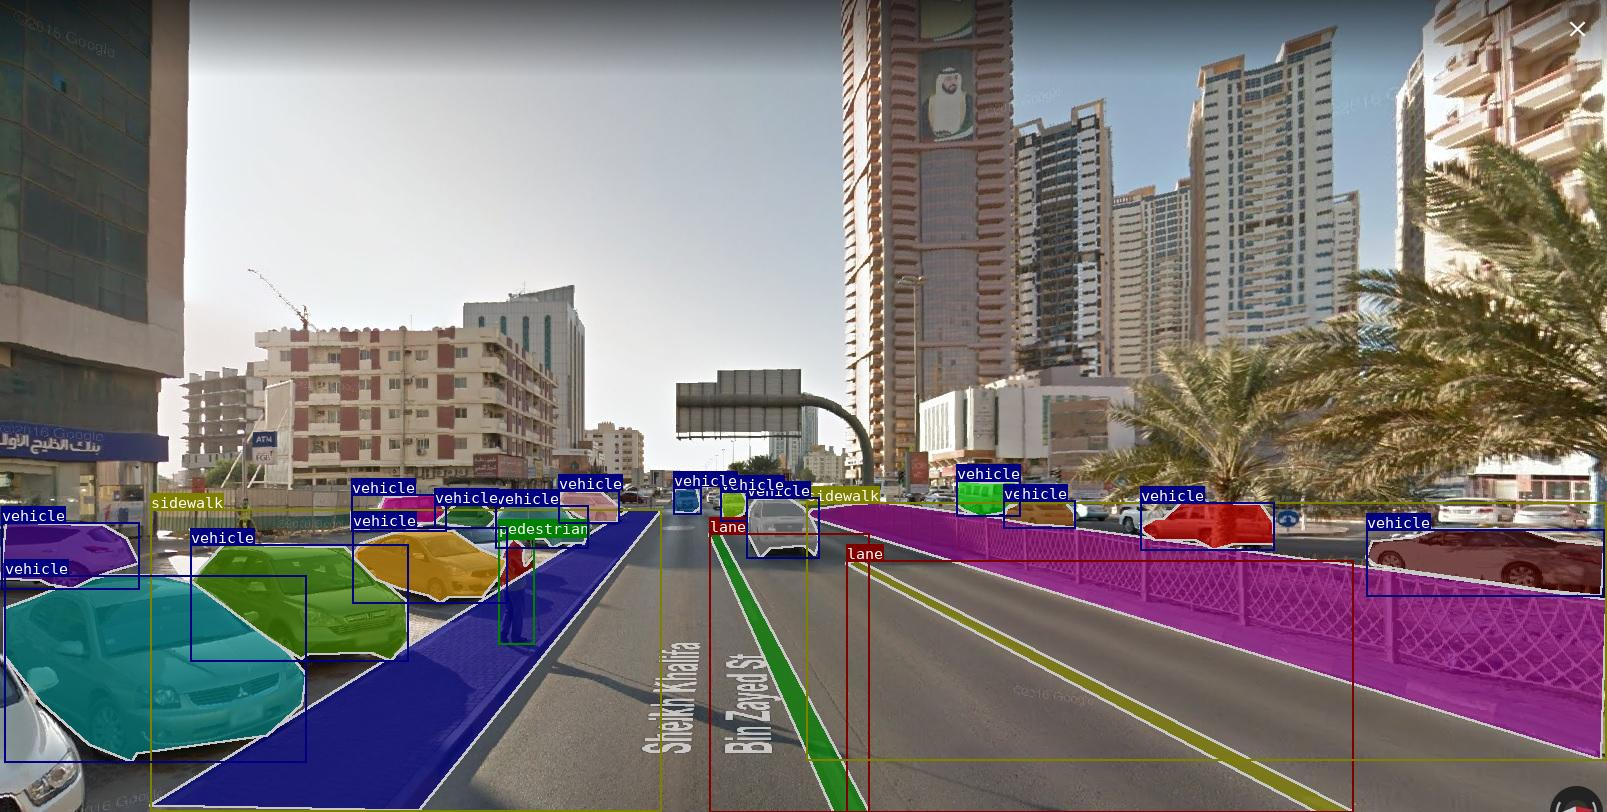

In [13]:
image_dir = 'train/Visualization'
filename = 'street_train_15.jpg'
full_path = os.path.join(image_dir, filename)
with tf1.gfile.GFile(full_path, 'rb') as fid:
    encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
image

***
***

  
  **Creating Label map**

In [11]:
#Create Label Map
labels = [{'name':'lane', 'id':1},{'name':'pedestrian', 'id':2},{'name':'sidewalk', 'id':3},{'name':'vehicle', 'id':4}]

with open('label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item{ \n')
        f.write('\tid:{}\n'.format(label['id']))
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('}\n')

***
***

**Creating tfrecords:**  
running the below command in Anaconda prompt:  

**python create_coco_tf_record.py --logtostderr --train_image_dir=images/train --test_image_dir=images/test --train_annotations_file=train/annotations.json --test_annotations_file=test/annotations.json --output_dir=tfrecords --include_masks**  

You can run the same in notebook:


In [ ]:
!python create_coco_tf_record.py --logtostderr --train_image_dir=images/train --test_image_dir=images/test --train_annotations_file=train/annotations.json --test_annotations_file=test/annotations.json --output_dir=tfrecords --include_masks

***
**Downloading the mask_rcnn model from Tensorflow model zoo**
***

**Type the follwoing commads in Notebook**

In [11]:
#Download the pretrained model (uncomment the below line)
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz

# Unzip the files (uncomment the below line)
!tar -xf mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz

#Moving the model (You need to change the base path according to your machine)
!move C:/Users/Windows10-Desktop/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8 C:/Users/Windows10-Desktop/Custome_Mask-R-CNN-model_Tensorflow_Object_Detection_API_Windows

#Copy the config file (You need to change the base path according to your machine)(its recomended to use the the same piprline.config file under 'model/pipeline.config becuase many changes have been made on this file to facialte the training on windows modest machine)')
#!copy C:\Users\Windows10-Desktop\Tensorflow-Object-Detection-API-train-custom-Mask-R-CNN-model\mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8\pipeline.config C:\Users\Windows10-Desktop\Tensorflow-Object-Detection-API-train-custom-Mask-R-CNN-model\model\pipeline.config

--2021-04-07 13:24:02--  http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4019:80b::2010, 172.217.21.48
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4019:80b::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484546405 (462M) [application/x-tar]
Saving to: 'mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz.2'

     0K .......... .......... .......... .......... ..........  0%  478K 16m29s
    50K .......... .......... .......... .......... ..........  0%  468K 16m39s
   100K .......... .......... .......... .......... ..........  0% 4.50M 11m40s
   150K .......... .......... .......... .......... ..........  0%  733K 11m27s
   200K .......... .......... .......... .......... ..........  0% 1.65M 10m5s
   250K .......... .......... .......... .......... ..........  0%  87

124600K .......... .......... .......... .......... .......... 26% 1.53M 3m59s
124650K .......... .......... .......... .......... .......... 26% 1.46M 3m59s
124700K .......... .......... .......... .......... .......... 26% 1.43M 3m59s
124750K .......... .......... .......... .......... .......... 26% 1.53M 3m59s
124800K .......... .......... .......... .......... .......... 26% 1.47M 3m59s
124850K .......... .......... .......... .......... .......... 26% 1.50M 3m59s
124900K .......... .......... .......... .......... .......... 26% 1.50M 3m59s
124950K .......... .......... .......... .......... .......... 26% 1.53M 3m59s
125000K .......... .......... .......... .......... .......... 26% 1.48M 3m59s
125050K .......... .......... .......... .......... .......... 26% 1.50M 3m59s
125100K .......... .......... .......... .......... .......... 26% 1.53M 3m59s
125150K .......... .......... .......... .......... .......... 26% 1.50M 3m59s
125200K .......... .......... .......... .......... 

249600K .......... .......... .......... .......... .......... 52% 1.50M 2m35s
249650K .......... .......... .......... .......... .......... 52% 1.51M 2m34s
249700K .......... .......... .......... .......... .......... 52% 1.53M 2m34s
249750K .......... .......... .......... .......... .......... 52% 1.46M 2m34s
249800K .......... .......... .......... .......... .......... 52% 1.50M 2m34s
249850K .......... .......... .......... .......... .......... 52% 1.48M 2m34s
249900K .......... .......... .......... .......... .......... 52% 1.54M 2m34s
249950K .......... .......... .......... .......... .......... 52% 1.47M 2m34s
250000K .......... .......... .......... .......... .......... 52% 1.57M 2m34s
250050K .......... .......... .......... .......... .......... 52% 1.50M 2m34s
250100K .......... .......... .......... .......... .......... 52% 1.46M 2m34s
250150K .......... .......... .......... .......... .......... 52% 1.51M 2m34s
250200K .......... .......... .......... .......... 

399550K .......... .......... .......... .......... .......... 84% 1.47M 50s
399600K .......... .......... .......... .......... .......... 84% 1.45M 50s
399650K .......... .......... .......... .......... .......... 84% 1.51M 50s
399700K .......... .......... .......... .......... .......... 84% 1.53M 50s
399750K .......... .......... .......... .......... .......... 84% 1.47M 50s
399800K .......... .......... .......... .......... .......... 84% 1.49M 50s
399850K .......... .......... .......... .......... .......... 84% 1.48M 50s
399900K .......... .......... .......... .......... .......... 84% 1.56M 50s
399950K .......... .......... .......... .......... .......... 84% 1.46M 50s
400000K .......... .......... .......... .......... .......... 84% 1.50M 50s
400050K .......... .......... .......... .......... .......... 84% 1.50M 50s
400100K .......... .......... .......... .......... .......... 84% 1.53M 50s
400150K .......... .......... .......... .......... .......... 84% 1.46M 50s

        1 dir(s) moved.


***
**Preparing the Configuration file pipeline.config**
***

**Its recommend to use the same pipeline config file under model folder because many changes have been applied to this file to facilitate the training on windows machine with modest RAM (Example: number of batches set to 1), you can modify the number of classes and keep the rest of details as is, otherwise you can use the master file from Tensorflow zoo and apply the required changes by your self(un-Markdown the below cells)**

#Defining the required paths:
model_path = 'model'
config_path = 'model/pipeline.config'

# configure the config file
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(config_path, 'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str,pipeline_config)

pipeline_config.train_config.fine_tune_checkpoint ='mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8/checkpoint/ckpt-0'
pipeline_config.model.faster_rcnn.num_classes = 3
pipeline_config.train_config.batch_size = 1
pipeline_config.train_config.fine_tune_checkpoint = config_path
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.eval_input_reader[0].label_map_path = 'label_mab.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = ["tfrecords/train.record"]
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = ["tfrecords/test.record"]

# write the changes to config file
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(config_path, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text) 

***
**Training**
***

Running the below line in Anaconda prompt:  

**python model_main_tf2.py --model_dir=model --pipeline_config_path=model\pipeline.config --num_train_steps=3000**

In [ ]:
!python model_main_tf2.py --model_dir=model --pipeline_config_path=model\pipeline.config --num_train_steps=3000

***

**Inference**

***

**You can find many videos under video folder to run the inference**

In [ ]:
# Load pipeline config and build a detection model

configs = config_util.get_configs_from_pipeline_file(config_path)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_path, 'ckpt-4')).expect_partial()

In [4]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [5]:
# Creating category_index
category_index = label_map_util.create_category_index_from_labelmap('Custome_Mask-R-CNN-model_Tensorflow_Object_Detection_API_Windows/label_map.pbtxt')
category_index

{1: {'id': 1, 'name': 'lane'},
 2: {'id': 2, 'name': 'pedestrian'},
 3: {'id': 3, 'name': 'sidewalk'},
 4: {'id': 4, 'name': 'vehicle'}}

In [25]:
### Setup capture
cap = cv2.VideoCapture('Custome_Mask-R-CNN-model_Tensorflow_Object_Detection_API_Windows/videos/video_5.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Store the videos under video folder
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('Custome_Mask-R-CNN-model_Tensorflow_Object_Detection_API_Windows/videos/mask_5.mp4',fourcc, 25.0, (width,height),isColor=True)

In [ ]:
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key:value[0, :num_detections].numpy() for key, value in detections.items() if key != 'num_proposals' and key != 'image_shape' } 
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    if 'detection_masks' in detections:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(tf.convert_to_tensor(detections['detection_masks']),tf.convert_to_tensor(detections['detection_boxes']),image_np.shape[0], image_np.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        detections['detection_masks_reframed'] = detection_masks_reframed.numpy()

    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                instance_masks=detections.get('detection_masks_reframed', None),
                use_normalized_coordinates=True,
                max_boxes_to_draw=100,
                min_score_thresh=.7,
                agnostic_mode=False)

    # cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (1000, 600)))
    out.write(image_np_with_detections)
    
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        break